In [18]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
from cmocean import cm as cmo
plt.style.use('seaborn-poster')
plt.style.use('ggplot')

import numpy as np
import pandas as pd
import xarray as xr
import scipy
import glob
import matplotlib.dates as mdates
import datetime
import dask.array as da

In [19]:
pathdat = "../data/track_data/csvs/Isaias_2020.csv"
df = pd.read_csv(pathdat)
hurrlats, hurrlons = df['LAT'].values, df['LON'].values

In [20]:
hurrtnum = np.ones_like(hurrlats)
for i in range(len(hurrlats)):
    hdate = datetime.datetime.strptime(df['DATE'][i]+" "+df['ISO_TIME_________'][i], "%m/%d/%y %H:%M:%S")
    hurrtnum[i] = mdates.date2num(hdate)

In [21]:
dataloc = "http://gliders.ioos.us/thredds/dodsC/deployments/rutgers/ng619-20200722T1900/ng619-20200722T1900.nc3.nc?trajectory[0:1:0],wmo_id[0:1:0],time[0:1:0][0:1:8604],latitude[0:1:0][0:1:8604],longitude[0:1:0][0:1:8604],time_uv[0:1:0][0:1:8604],lat_uv[0:1:0][0:1:8604],lon_uv[0:1:0][0:1:8604],precise_time[0:1:0][0:1:8604][0:1:268],depth[0:1:0][0:1:8604][0:1:268],pressure[0:1:0][0:1:8604][0:1:268],temperature[0:1:0][0:1:8604][0:1:268],conductivity[0:1:0][0:1:8604][0:1:268],salinity[0:1:0][0:1:8604][0:1:268],density[0:1:0][0:1:8604][0:1:268]"
df      = xr.open_dataset(dataloc, decode_times=False)

In [22]:
dataAS  = "../data/AtlanticShores_833d_ebdb_69d0_d81b_55e4_f5f5.nc"
dataASwinds = "../data/AtlanticShores_Isaias_Winds.nc"
dAS     = xr.open_dataset(dataAS)
dAw     = xr.open_dataset(dataASwinds)

In [23]:
dAS.time[0].values, dAS.time[-1].values, 

(numpy.datetime64('2020-07-21T00:00:00.000000000'),
 numpy.datetime64('2020-09-22T21:00:00.000000000'))

In [24]:
dAw.altitude

<xarray.DataArray 'altitude' (row: 62326)>
array([ 10.,  40.,  60., ..., 180., 200., 250.])
Dimensions without coordinates: row
Attributes:
    _CoordinateAxisType:     Height
    _CoordinateZisPositive:  up
    actual_range:            [ 10. 250.]
    axis:                    Z
    colorBarMaximum:         8000.0
    colorBarMinimum:         -8000.0
    colorBarPalette:         TopographyDepth
    ioos_category:           Location
    long_name:               Altitude
    positive:                up
    source_name:             height
    standard_name:           altitude
    units:                   m

In [25]:
start = mdates.date2num(datetime.datetime(2020,8,4,0))
enddd = mdates.date2num(datetime.datetime(2020,8,5,18))
myFmt = mdates.DateFormatter('%m/%d\n%H:%M')

In [26]:
vellen = len(dAS.sea_water_speed[::34].values)

cross_shelf_u = np.ones((34,vellen))
u_angle       = np.ones((34,vellen))
along_shelf_v = np.ones((34,vellen))
coast_angle   = 0

for i in range(34):
    cross_shelf_u[i,:] = dAS.sea_water_speed[i::34].values*np.cos(np.deg2rad(dAS.sea_water_velocity_to_direction[i::34].values + coast_angle))
    u_angle[i,:]       = np.mod(np.deg2rad(dAS.sea_water_velocity_to_direction[i::34].values + coast_angle),2*np.pi)
    along_shelf_v[i,:] = dAS.sea_water_speed[i::34].values*np.sin(np.deg2rad(dAS.sea_water_velocity_to_direction[i::34].values + coast_angle))
    
depths = -1*(np.arange(34)+3)
times  = mdates.date2num(dAS.time[::34])

In [27]:
depths

array([ -3,  -4,  -5,  -6,  -7,  -8,  -9, -10, -11, -12, -13, -14, -15,
       -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28,
       -29, -30, -31, -32, -33, -34, -35, -36])

/Users/cew145/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


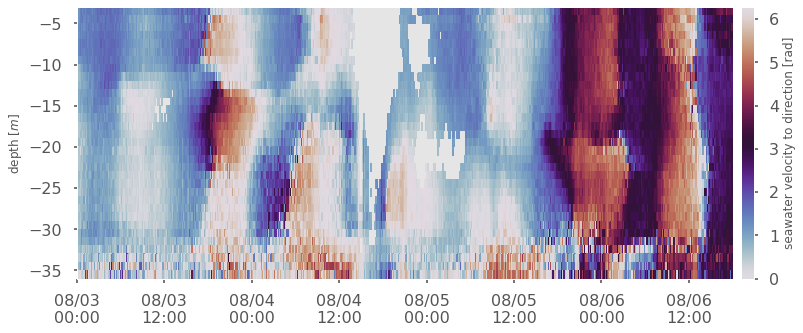

In [28]:
plt.figure(figsize=(14,5))
plt.pcolor(times, depths, u_angle, vmin=0, vmax=2*np.pi, cmap='twilight')
plt.colorbar(pad=0.01, label="seawater velocity to direction [rad]")
plt.xlim([start-1, enddd+1])
plt.ylabel('depth [$m$]')
plt.gca().xaxis.set_major_formatter(myFmt)
# save the plot as a file
plt.savefig('Isaias_AtlanticShores_theta.png', bbox_inches='tight', dpi=200)
plt.show()

/Users/cew145/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


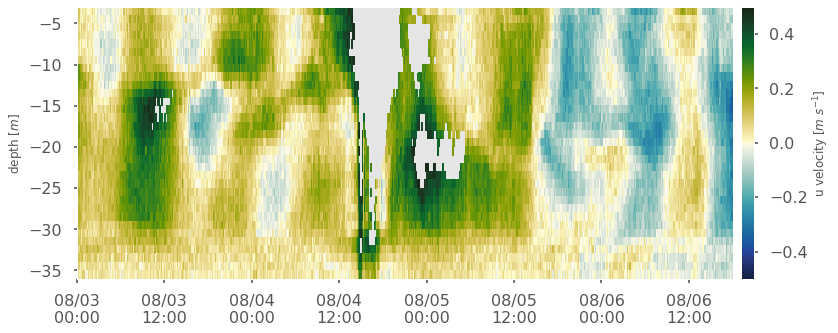

In [29]:
plt.figure(figsize=(14,5))
plt.pcolor(times, depths, cross_shelf_u/100, vmax=0.5, vmin=-0.5, cmap='cmo.delta')
plt.colorbar(pad=0.01, label="u velocity [$m$ $s^{-1}$]")
plt.xlim([start-1, enddd+1])
plt.ylabel('depth [$m$]')
plt.gca().xaxis.set_major_formatter(myFmt)
# save the plot as a file
#plt.savefig('Isaias_AtlanticShores_u.png', bbox_inches='tight', dpi=200)
plt.show()

/Users/cew145/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


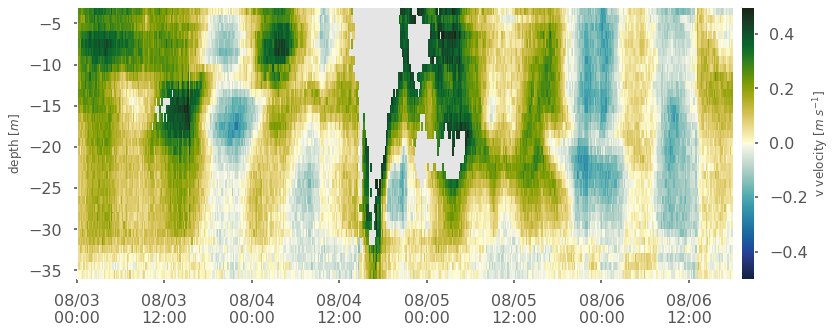

In [30]:
plt.figure(figsize=(14,5))
plt.pcolor(times, depths, along_shelf_v/100, vmax=0.5, vmin=-0.5, cmap='cmo.delta')
plt.colorbar(pad=0.01, label="v velocity [$m$ $s^{-1}$]")
plt.xlim([start-1, enddd+1])
plt.ylabel('depth [$m$]')
plt.gca().xaxis.set_major_formatter(myFmt)
# save the plot as a file
plt.savefig('Isaias_AtlanticShores_v.png', bbox_inches='tight', dpi=200)
plt.show()

In [31]:
dudz = np.gradient(cross_shelf_u,axis=0)/100
dvdz = np.gradient(along_shelf_v,axis=0)/100
S2   = dudz**2 + dvdz**2

In [32]:
wind_dnum = mdates.date2num(dAw.time)
wind_sped = dAw.wind_speed.values
wind_dfro = dAw.wind_from_direction.values

gw = np.where(wind_sped < 50)
wind_dnum = wind_dnum[gw]
wind_sped = wind_sped[gw]
wind_dfro = wind_dfro[gw]

gw = np.where(wind_dfro > 1)
wind_dnum = wind_dnum[gw]
wind_sped = wind_sped[gw]
wind_dfro = wind_dfro[gw]

In [33]:
dAw.wind_from_direction

<xarray.DataArray 'wind_from_direction' (row: 62326)>
array([2.333809e+02, 6.055000e-02, 2.282549e+02, ..., 3.717969e+01,
       3.541211e+01, 3.717969e+01])
Dimensions without coordinates: row
Attributes:
    actual_range:           [ -1.      360.82324]
    colorBarMaximum:        360.0
    colorBarMinimum:        0.0
    coverage_content_type:  physicalMeasurement
    ioos_category:          Wind
    long_name:              Wind From Direction
    standard_name:          wind_from_direction
    units:                  degree

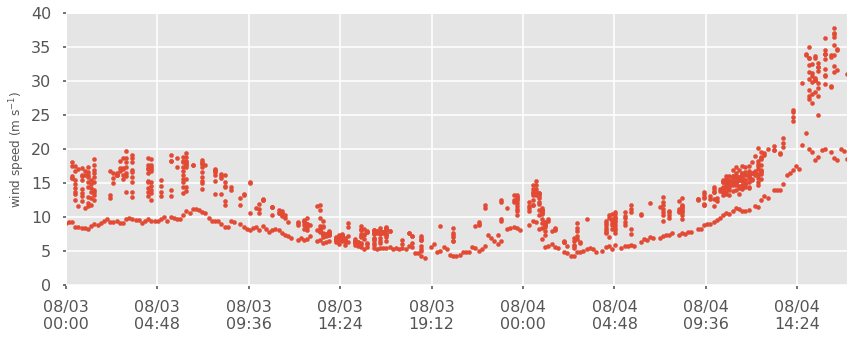

In [34]:
plt.figure(figsize=(14,5))
plt.scatter(wind_dnum, wind_sped, s=16)
plt.ylabel('wind speed (m s$^{-1}$)')
plt.xlim([start-1, enddd-1-1/24])
plt.ylim([0,40])
#plt.grid(c='k', linestyle='--', alpha=0.5)
plt.gca().xaxis.set_major_formatter(myFmt)

plt.show()

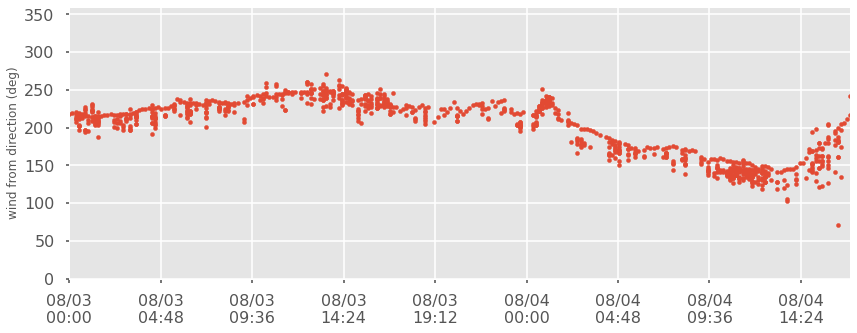

In [35]:
plt.figure(figsize=(14,5))
plt.scatter(wind_dnum, wind_dfro, s=16)
plt.ylabel('wind from direction (deg)')
plt.xlim([start-1, enddd-1-1/24])
plt.ylim([0,360])
#plt.grid(c='k', linestyle='--', alpha=0.5)
plt.gca().xaxis.set_major_formatter(myFmt)

plt.show()

In [36]:
ga = wind_dnum < enddd-1-1/24
gb = wind_dnum > start-1
gw = np.logical_and(ga,gb)
AL_dnum = wind_dnum[gw]
AL_sped = wind_sped[gw]
AL_dfro = wind_dfro[gw]

angle_of_coast = 210
dt_AL   = np.gradient(AL_dnum*86400)

$\tau^s = \rho_{air} C_D (U_w - U)^2 $

$ \Delta X = \int^t dt \frac{\tau^s(t)}{\rho_o f \delta_E} $

In [37]:
CD     = 2e-3  # 
rhoair = 1.225 # kg/m³
rhowat = 1022  # kg/m³
deltaE = 10    # m
DeltaX = 0     # m
f      = 1e-4  # 1/s
for i, dt in enumerate(dt_AL):
    tau_s   = rhoair*CD*AL_sped[i]**2
    DeltaX += dt * tau_s / (rhowat * deltaE * f)

In [38]:
DeltaX/1000

48.13393764671447

/Users/cew145/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


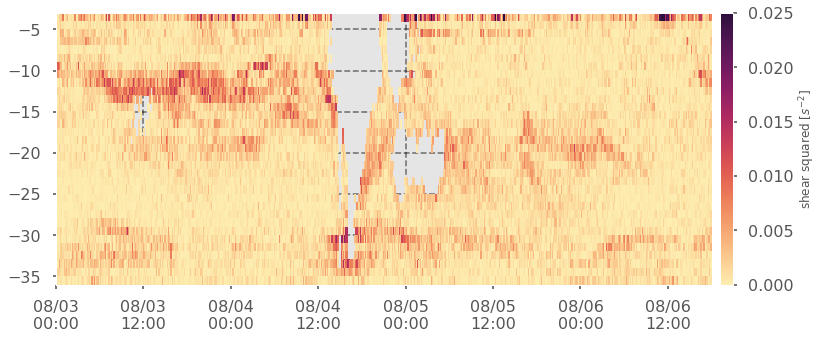

In [39]:
plt.figure(figsize=(14,5))
plt.pcolor(times, depths, S2, vmax=0.025, vmin=0, cmap='cmo.matter')
plt.colorbar(pad=0.01, label="shear squared [$s^{-2}$]")
plt.xlim([start-1, enddd+1])
plt.gca().xaxis.set_major_formatter(myFmt)
plt.grid(c='k', linestyle='--', alpha=0.5)
# save the plot as a file
plt.savefig('Isaias_AtlanticShores_S2.png', bbox_inches='tight', dpi=200)
plt.show()

In [40]:
time_origin = datetime.datetime(1970,1,1)
datenum = np.ones_like(df.depth.values)
dlen    = np.shape(df.depth)[2]
for i, sec in enumerate(df.time.values[0,:]):
    datetmp   = time_origin + datetime.timedelta(seconds = sec)
    datenum[0,i,:] = mdates.date2num(datetmp)*np.ones(dlen)

In [41]:
dP = np.gradient(df.depth[0,:,:].values, axis=(1))
dt = np.gradient(datenum, axis=(1)) / 96400
dPdt = dP/dt

/Users/cew145/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/cew145/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [42]:
glats = np.squeeze(df.latitude.values)
glons = np.squeeze(df.longitude.values)

distance_metric = np.ones((np.size(glats),np.size(hurrlats)))
for i, glatitude in enumerate(glats):
    for j, hlatitude in enumerate(hurrlats):
        latdist = glatitude - hlatitude
        londist = glons[i] - hurrlons[j]
        distance_metric[i,j] = np.sqrt(latdist**2 + londist**2)

b = np.amin(distance_metric)
ktime = np.where(distance_metric == b)[1][0]
eyepassage = hurrtnum[ktime]

In [43]:
start = eyepassage - 4
enddd = eyepassage + 2

In [44]:
### binning
x = datenum[0,:,:].reshape(np.size(datenum[0,:,:]))
y = -df.depth[0,:,:].values.reshape(np.size(datenum[0,:,:]))
t = df.temperature[0,:,:].values.reshape(np.size(datenum[0,:,:]))
s = df.salinity[0,:,:].values.reshape(np.size(datenum[0,:,:]))
timepoints = int((enddd - start)*24)+1 #
tgrid = np.linspace(start,enddd,timepoints)
zgrid = np.linspace(-93,-3,46)
T, Z = np.meshgrid(tgrid,zgrid)

In [45]:
TEMPS = np.ones_like(T)
SALT = np.ones_like(T)
np.shape(TEMPS)

(46, 145)

In [46]:
for i in range(len(tgrid)-1):
    Tmore = x > tgrid[i]
    Tless = x < tgrid[i+1]
    qT = np.logical_and(Tmore,Tless)
    for j in range(len(zgrid)-1):
        Zmore = y > zgrid[j]
        Zless = y < zgrid[j+1]
        qZ = np.logical_and(Zmore,Zless)
        qALL = np.logical_and(qZ,qT)
        xZ = x[qALL]
        yZ = y[qALL]
        tZ = t[qALL]
        sZ = s[qALL]
        if len(tZ) > 0:
            TEMPS[j,i] = np.nanmedian(tZ)
            SALT[j,i] = np.nanmedian(sZ)
        else:
            TEMPS[j,i] = np.nan
            SALT[j,i] = np.nan

/Users/cew145/miniconda3/envs/pangeo/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


/Users/cew145/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


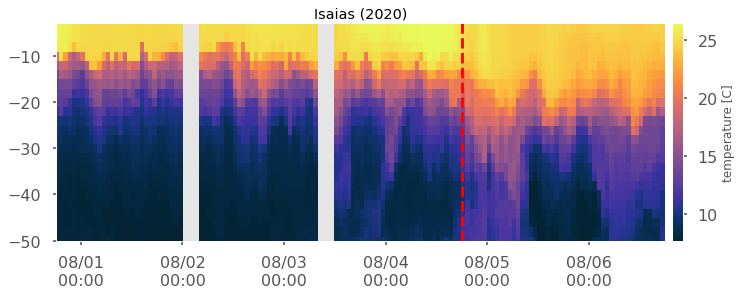

In [47]:
plt.figure(figsize=(13,4))
plt.pcolor(T, Z, TEMPS, cmap=cmo.thermal)
plt.colorbar(pad=0.01, label="temperature [C]")
plt.xlim([start, enddd])
plt.gca().xaxis.set_major_formatter(myFmt)
plt.ylim([-50,-3])
plt.axvline(x = eyepassage, c='r', linestyle="--")

#plt.scatter(ndb_datenum, -(windspeed), c=winddir, s=36, vmin=0, vmax=360, cmap=cmo.phase)
plt.title('Isaias (2020)')
plt.savefig("FIGS/temperatures_Isaias2020.pdf", bbox_inches='tight')
plt.show()

In [117]:
df.depth.values.shape

(1, 8605, 269)

In [119]:
df.temperature.shape

(1, 8605, 269)

In [150]:
dense0 = 1022.8
T0     = 17
S0     = 31.5
alpha  = 0.000281
beta   = 0.000766
g      = 9.81

dense = dense0 * (1 + alpha*(TEMPS-T0) + beta*(SALT-S0))
buoy  = -g * dense / dense0

dz = np.gradient(Z, axis=[0])
db = np.gradient(buoy, axis=[1])
dbdz = -db / dz

dbdz_b = dbdz[:,qb]
dbdz_b.shape
maxN2 = np.ones(dbdz_b.shape[1]-1)
for i in range(dbdz_b.shape[1]-1):
    prof = dbdz_b[i,:]
    maxN2[i] = np.nanmax(prof)
    
print("N2max =",np.nanmean(maxN2))

N2max = 0.002069113490300821


/Users/cew145/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


Text(0.5, 1.0, 'Isaias (2020)')

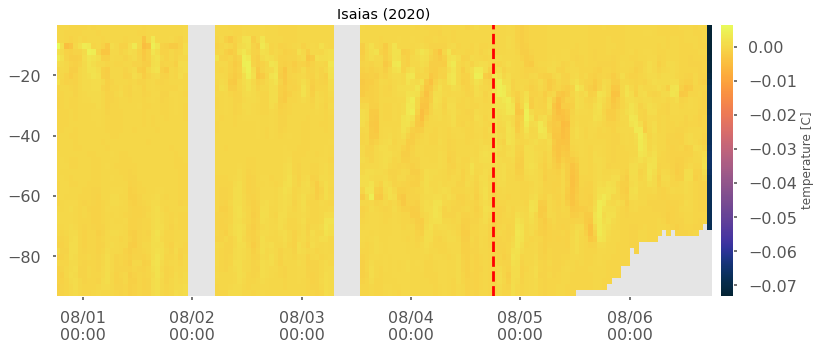

In [148]:
plt.figure(figsize=(14,5))
plt.pcolor(T, Z, dbdz, cmap=cmo.thermal)
plt.colorbar(pad=0.01, label="temperature [C]")
plt.xlim([start, enddd])
plt.gca().xaxis.set_major_formatter(myFmt)
plt.axvline(x = eyepassage, c='r', linestyle="--")

#plt.scatter(ndb_datenum, -(windspeed), c=winddir, s=36, vmin=0, vmax=360, cmap=cmo.phase)
plt.title('Isaias (2020)')

In [140]:
qb.shape, dbdz.shape, dbdz_b.shape[1]

((145,), (46, 145), 47)

In [135]:
bef = tgrid < eyepassage-0.5
aft = tgrid > eyepassage-2.5
qb   = np.logical_and(bef,aft)
temps_bef = TEMPS[:3,qb]
mean_Tbef = np.nanmean(temps_bef)

bef = tgrid < eyepassage+(1/24)
aft = tgrid > eyepassage-(1/24)
qeye  = np.logical_and(bef,aft)
temps_eye = TEMPS[:3,qeye]
mean_Teye = np.nanmean(temps_eye)

bef = tgrid < eyepassage+0.5
aft = tgrid > eyepassage+0.25
qa   = np.logical_and(bef,aft)
temps_aft = TEMPS[:3,qa]
mean_Taft = np.nanmean(temps_aft)

Ahead_of_eye_cooling = mean_Tbef - mean_Teye
After_of_eye_cooling = mean_Teye - mean_Taft

print(Ahead_of_eye_cooling, After_of_eye_cooling)

-0.0051022832707836585 -0.5468379974365245


In [109]:
def pycnocline_width(profile_tmp, d, low=10.5, high=11.5):
    finite = np.where(np.isfinite(profile_tmp))[0]
    d=np.abs(d)
    maxdepth = d[np.min(finite)]
    mindepth = d[np.max(finite)]
    try:
        new_d = np.arange(mindepth,maxdepth,0.1)
        y = interp.interp1d(d[finite],profile_tmp[finite], kind='linear')
        new_tmp = y(new_d)
        tmp_low = np.abs(new_tmp - low)
        tmp_high = np.abs(new_tmp - high)
        q_low = np.where(tmp_low == np.nanmin(tmp_low))[0][0]
        q_high = np.where(tmp_high == np.nanmin(tmp_high))[0][0]
        #delta_d = new_d[q_high] - new_d[q_low]
        return new_d[q_high], new_d[q_low]
    except:
        return np.nan, np.nan

import scipy.interpolate as interp

low_depth  = np.ones_like(tgrid)
high_depth = np.ones_like(tgrid)

d = zgrid

for I in range(len(tgrid)):
    profile_tmp = TEMPS[:,I]
    a, b = pycnocline_width(profile_tmp, d, low=16, high=19)
    if np.abs(a-b) < 0.25:
        low_depth[I], high_depth[I] = np.nan, np.nan
    else:
        low_depth[I], high_depth[I] = a, b

In [110]:
Pw_bef = np.nanmedian(low_depth[qb]-high_depth[qb])
Pw_eye = np.nanmedian(low_depth[qeye]-high_depth[qeye])
Pw_aft = np.nanmedian(low_depth[qa]-high_depth[qa])

Pw_bef, Pw_eye, Pw_aft, np.nanmean(high_depth[qb])-np.nanmean(high_depth[qeye])

(-3.400000000000002,
 -3.9000000000000057,
 -6.200000000000003,
 -4.95079365079366)

In [24]:
st = mdates.date2num(datetime.datetime(2020,8,2,12))
en = mdates.date2num(datetime.datetime(2020,8,3,18))

a = tgrid < en
b = tgrid > st
q = np.logical_and(a,b)
temps_before = TEMPS[:,q]
temps_before = np.nanmean(temps_before, axis=(1))

/Users/cew145/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


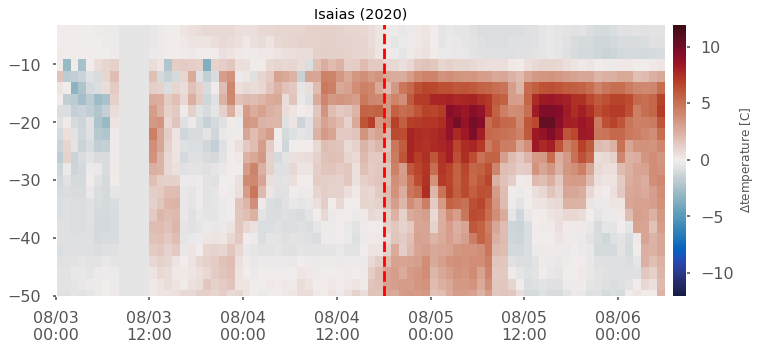

In [33]:
plt.figure(figsize=(13,5))
plt.pcolor(T, Z, TEMPS - temps_before[:,np.newaxis], cmap=cmo.balance, vmax =12, vmin=-12)
plt.colorbar(pad=0.01, label="$\Delta$temperature [C]")
#plt.xlim([start+1.5, enddd])
plt.gca().xaxis.set_major_formatter(myFmt)
plt.ylim([-50,-3])
plt.axvline(x = eyepassage, c='r', linestyle="--")
#plt.scatter(ndb_datenum, -(windspeed), c=winddir, s=36, vmin=0, vmax=360, cmap=cmo.phase)
plt.title('Isaias (2020)')
plt.savefig("FIGS/dT_Isaias2020.pdf", bbox_inches='tight')
plt.show()

In [52]:
winddata = "../data/ndbc_years/4406582020.txt"
winddat2 = "../data/ndbc_years/4400982020.txt"

ndb = pd.read_csv(winddata, skiprows=[1], delim_whitespace=True)
nd2 = pd.read_csv(winddat2, skiprows=[1], delim_whitespace=True)

In [53]:
list(ndb)

['#YY',
 'MM',
 'DD',
 'hh',
 'mm',
 'WDIR',
 'WSPD',
 'GST',
 'WVHT',
 'DPD',
 'APD',
 'MWD',
 'PRES',
 'ATMP',
 'WTMP',
 'DEWP',
 'VIS',
 'TIDE']

In [54]:
ndb_datenum = [mdates.date2num(datetime.datetime(ndb['#YY'][i],ndb['MM'][i],ndb['DD'][i],ndb['hh'][i],ndb['mm'][i])) 
               for i in range(len(ndb))]
ndb_datenum = np.asarray(ndb_datenum)

nd2_datenum = [mdates.date2num(datetime.datetime(nd2['#YY'][i],nd2['MM'][i],nd2['DD'][i],nd2['hh'][i],nd2['mm'][i])) 
               for i in range(len(nd2))]
nd2_datenum = np.asarray(nd2_datenum)

In [114]:
def cooling_defs_1D(datenums,eyepassage,wtemp):
    bef = datenums < eyepassage-0.5
    aft = datenums > eyepassage-2.0
    qb   = np.logical_and(bef,aft)
    temps_bef = wtemp[qb]
    mean_Tbef = np.nanmean(temps_bef)

    bef = datenums < eyepassage+(1/24)
    aft = datenums > eyepassage-(1/24)
    qeye  = np.logical_and(bef,aft)
    temps_eye = wtemp[qeye]
    mean_Teye = np.nanmean(temps_eye)

    bef = datenums < eyepassage+0.5
    aft = datenums > eyepassage+0.25
    qa   = np.logical_and(bef,aft)
    temps_aft = wtemp[qa]
    mean_Taft = np.nanmean(temps_aft)

    Ahead_of_eye_cooling = mean_Tbef - mean_Teye
    After_of_eye_cooling = mean_Teye - mean_Taft

    return(Ahead_of_eye_cooling, After_of_eye_cooling)

In [115]:
cooling_defs_1D(ndb_datenum,eyepassage,ndb['WTMP'].values)

(7.833784355179702, 0.524155844155846)

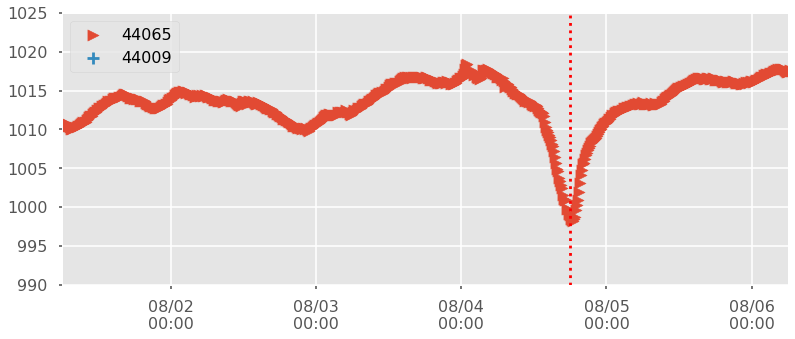

In [112]:
plt.figure(figsize=(13,5))
plt.scatter(ndb_datenum, ndb['PRES'], marker=">", label="44065")
#plt.scatter(nd2_datenum, nd2['PRES'], c=nd2['WTMP'], vmin=15, vmax=27, cmap=cmo.thermal, marker="+", label="44009")
plt.xlim([start+0.5, enddd-0.5])
plt.legend()
plt.axvline(x = eyepassage, c='r', linestyle=":")
plt.ylim([990,1025])
plt.gca().xaxis.set_major_formatter(myFmt)

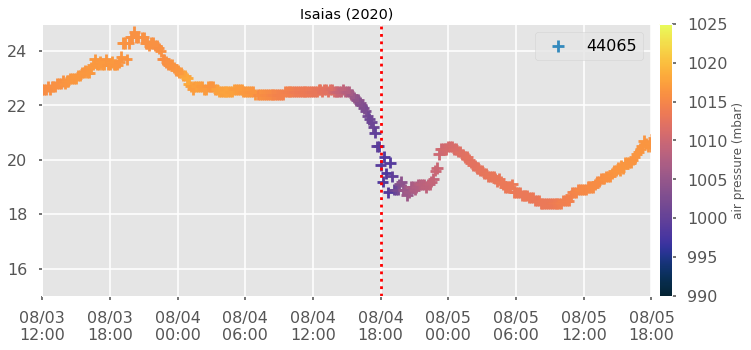

In [83]:
plt.figure(figsize=(13,5))
plt.scatter(ndb_datenum, ndb['WTMP'], c=ndb['PRES'], vmin=990, vmax=1025, cmap=cmo.thermal, marker="+", label="44065")
#plt.scatter(nd2_datenum, nd2['PRES'], c=nd2['WTMP'], vmin=15, vmax=27, cmap=cmo.thermal, marker="+", label="44009")
plt.colorbar(pad=0.01,label='air pressure (mbar)')
plt.xlim([start+0.5, enddd-0.5])
plt.legend()
plt.axvline(x = eyepassage, c='r', linestyle=":")
plt.ylim([15,25])
plt.gca().xaxis.set_major_formatter(myFmt)
plt.title('Isaias (2020)')
plt.savefig("FIGS/wTnP_Isaias2020.pdf", bbox_inches='tight')

In [62]:
windspeed = np.ones_like(ndb['WSPD'][:])
winddir   = np.ones_like(ndb['WSPD'][:])
wtemp     = np.ones_like(ndb['WSPD'][:])
airpress  = np.ones_like(ndb['WSPD'][:])

for i, wspd in enumerate(ndb['WSPD'][:]):
    try:
        windspeed[i] = np.float(wspd)
        winddir[i]   = np.float(ndb['WDIR'][i])
        wtemp[i]     = np.float(ndb['WTMP'][i])
        airpress[i]  = np.float(ndb['PRES'][i])
    except:
        windspeed[i] = np.nan
        winddir[i]   = np.nan
        wtemp[i]     = np.nan
        airpress[i]  = np.nan

windspee2 = np.ones_like(nd2['WSPD'][:])
winddi2   = np.ones_like(nd2['WSPD'][:])
wtem2     = np.ones_like(nd2['WSPD'][:])
airpres2  = np.ones_like(nd2['WSPD'][:])

for i, wspd in enumerate(nd2['WSPD'][:]):
    try:
        windspee2[i] = np.float(wspd)
        winddi2[i]   = np.float(nd2['WDIR'][i])
        wtem2[i]     = np.float(nd2['WTMP'][i])
        airpres2[i]  = np.float(nd2['PRES'][i])
    except:
        windspee2[i] = np.nan
        winddi2[i]   = np.nan
        wtem2[i]     = np.nan
        airpres2[i]  = np.nan

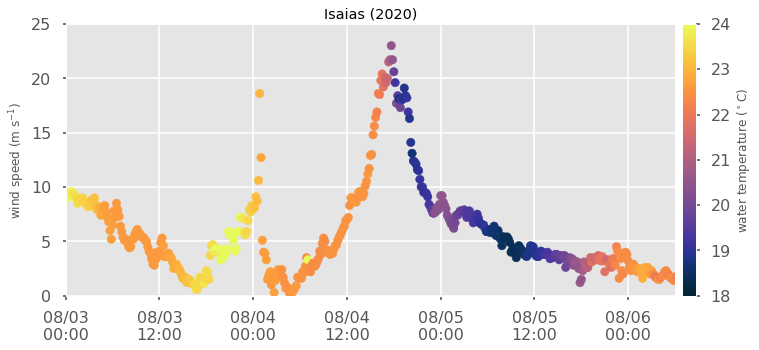

In [65]:
plt.figure(figsize=(13,5))
plt.scatter(ndb_datenum, windspeed, c=wtemp, cmap=cmo.thermal, s=70, vmin=18, vmax=24)
plt.colorbar(pad=0.01, label='water temperature ($^\circ$C)')
plt.ylabel('wind speed (m s$^{-1}$)')
plt.ylim([0, 25])
plt.xlim([start, enddd])
plt.title('Isaias (2020)')
plt.gca().xaxis.set_major_formatter(myFmt)

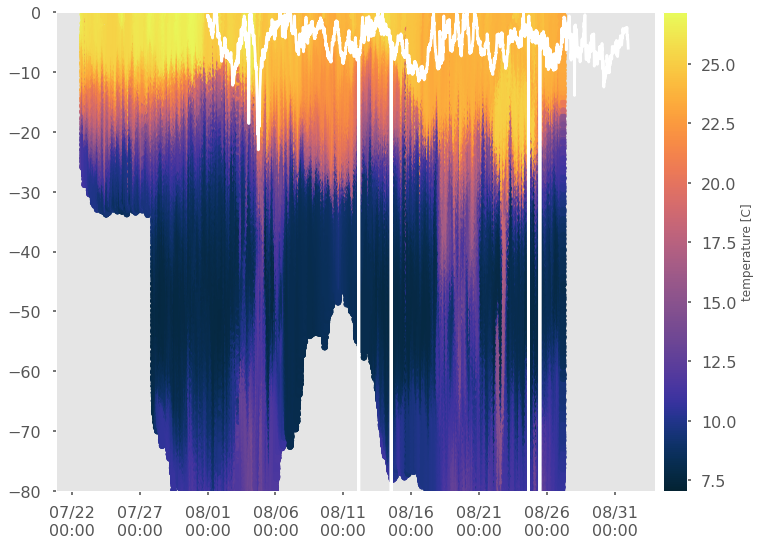

In [84]:
plt.scatter(datenum[0,:,:], -df.depth[0,:,:], c=df.temperature[0,:,:], s=36, cmap=cmo.thermal)
plt.colorbar(pad=0.01, label="temperature [C]")
plt.plot(ndb_datenum, -1*(windspeed), c='w')
#plt.xlim([mdates.date2num(datetime.datetime(2020,8,4,12)), mdates.date2num(datetime.datetime(2020,8,4,18))])
plt.ylim([-80,0])
plt.gca().xaxis.set_major_formatter(myFmt)
plt.grid()
plt.show()

In [34]:
depthlines = np.arange(50)+5
casttimes = datenum[0,:,0]
np.shape(casttimes)

DLINES, CTIMES = np.meshgrid(depthlines, casttimes)

In [35]:
np.shape(DLINES)

(8605, 50)

In [36]:
TLINES = np.ones_like(DLINES) * np.nan

for i, tnum in enumerate(casttimes[:]):
    d = df.depth[0,i,:].values
    temps = df.temperature[0,i,:].values
    maxD = np.nanmax(d)
    tgood = temps[np.isfinite(temps)]
    dgood = d[np.isfinite(temps)]
    sortq = np.argsort(dgood)
    tgood = tgood[sortq]
    dgood = dgood[sortq]
    q = np.where(depthlines < maxD)
    xx = depthlines[q]
    TLINES[i,:len(xx)] = np.interp(xx,dgood,tgood)
    #plt.plot(xx, np.interp(xx,dgood,tgood))

In [37]:
import scipy.interpolate as interp

def pycnocline_width(profile_tmp, d, low=10.5, high=11.5):
    finite = np.where(np.isfinite(profile_tmp))[0]
    maxdepth = d[np.min(finite)]
    mindepth = d[np.max(finite)]
    new_d = np.arange(mindepth,maxdepth,0.1)
    y = interp.interp1d(d[finite],profile_tmp[finite], kind='linear')
    new_tmp = y(new_d)
    tmp_low = np.abs(new_tmp - low)
    tmp_high = np.abs(new_tmp - high)
    q_low = np.where(tmp_low == np.nanmin(tmp_low))[0][0]
    q_high = np.where(tmp_high == np.nanmin(tmp_high))[0][0]
    #delta_d = new_d[q_high] - new_d[q_low]
    return new_d[q_high], new_d[q_low]

np.shape(TLINES)

(8605, 50)

In [38]:
low_depth  = np.ones_like(casttimes)
high_depth = np.ones_like(casttimes)

for I in range(len(casttimes)):
    new_tmp = TLINES[I,:]
    if sum(np.isfinite(new_tmp)) > 3:
        tmp_low = np.abs(new_tmp - 16)
        tmp_high = np.abs(new_tmp - 22)
        q_low = np.where(tmp_low == np.nanmin(tmp_low))[0][0]
        q_high = np.where(tmp_high == np.nanmin(tmp_high))[0][0]
        a, b = depthlines[q_high], depthlines[q_low]
        if np.abs(a-b) < 0.25:
            low_depth[I], high_depth[I] = np.nan, np.nan
        else:
            low_depth[I], high_depth[I] = a, b
    else: low_depth[I], high_depth[I] = np.nan, np.nan

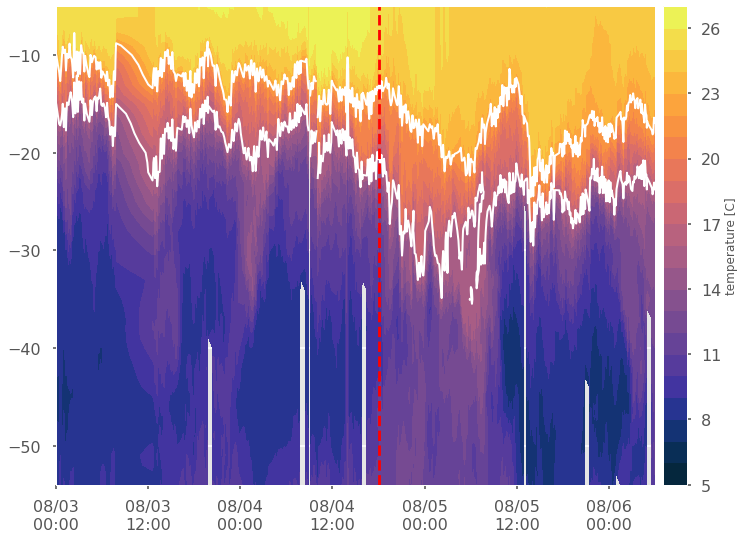

In [39]:
plt.contourf(CTIMES, -DLINES, TLINES, cmap='cmo.thermal', levels=np.arange(23)+5)
plt.xlim([start, enddd])
plt.colorbar(pad=0.01, label="temperature [C]")
plt.contour(CTIMES, -DLINES, TLINES, levels=np.array([16,22]), colors='w', linewidths=2)
plt.axvline(x = eyepassage, c='r', linestyle="--")
#plt.plot(ndb_datenum, 1*(windspeed), c='r')
plt.gca().xaxis.set_major_formatter(myFmt)
plt.savefig('Isaias_2020_wind.pdf', bbox_inches='tight')

Text(0, 0.5, 'pycnocline width [m]')

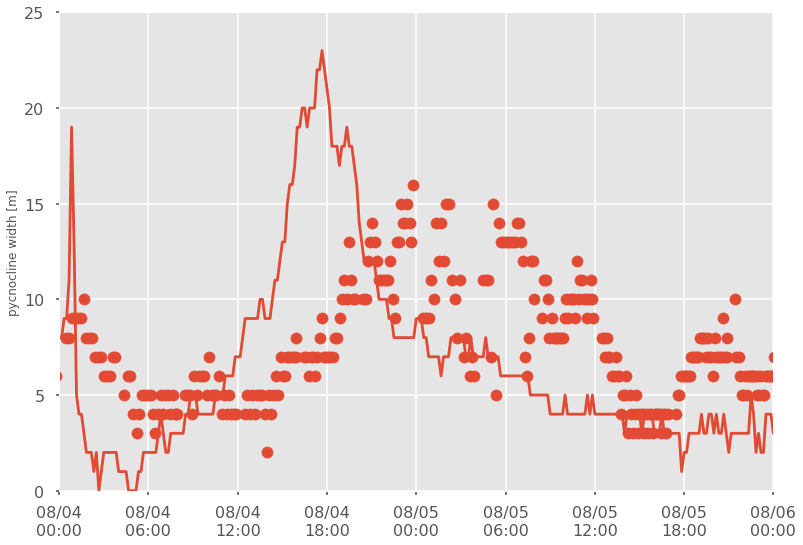

In [40]:
plt.scatter(casttimes, high_depth - low_depth)
plt.plot(ndb_datenum, (windspeed))
#plt.plot(ndb_datenum, (winddir)*np.pi/180)
plt.xlim([start+1, enddd-0.25])
plt.gca().xaxis.set_major_formatter(myFmt)
plt.ylim([0,25])
plt.ylabel('pycnocline width [m]')

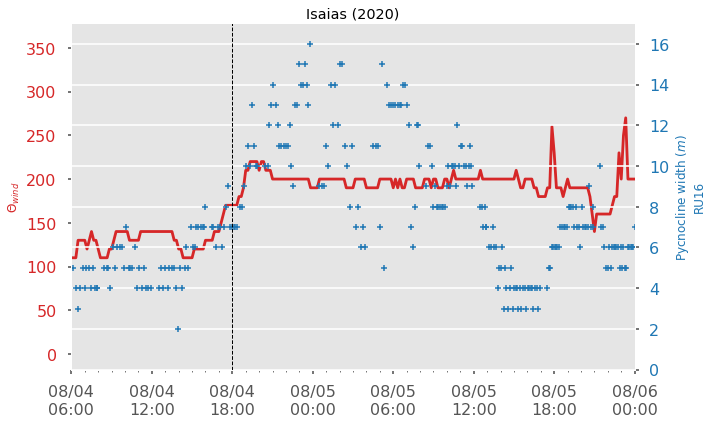

In [42]:
fig, ax1 = plt.subplots(figsize=(10,6))
plt.title('Isaias (2020)')
color = 'tab:red'
#ax1.set_xlabel('date in 2011')
ax1.set_ylabel(r'$\Theta_{wind}$', color=color)
ax1.plot(ndb_datenum, (winddir), color=color)
#ax1.plot(tck['datenum'],dtheta_tck_filt/dTtck /f, label='Tuckerton', color=color)
ax1.tick_params(axis='y', labelcolor=color)
#ax1.set_ylim([-1,2.5])
#ax1.grid(color=color, linestyle='-.', linewidth=0.2)
ax1.grid(False)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Pycnocline width ($m$)\nRU16', color=color)  # we already handled the x-label with ax1
ax2.scatter(casttimes, high_depth - low_depth, s=45, color=color, marker='+', linewidth=1.5)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim([0,17])
#ax2.grid(color=color, linestyle='-.', linewidth=0.2)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%m/%d\n%H:%M"))
ax2.xaxis.set_minor_locator(mdates.HourLocator(interval=1))
ax2.xaxis.set_major_locator(mdates.HourLocator(interval=6))
plt.gca().xaxis.grid(True)
plt.xlim([start+1.25, enddd-0.25])
plt.axvline(x = eyepassage, c='k', linestyle="--", linewidth=1)

fig.tight_layout() 
plt.savefig('Isaias_2020_wind.pdf', bbox_inches='tight')